In [10]:
import sys
sys.path.append('../')
sys.path.append('../support/')
from ct_reader import *
from glob import glob
import timeit
from os.path import join, basename, isfile
from tqdm import tqdm
from functools import partial
from paths import *
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import scale
import xgboost as xgb
from sklearn import cross_validation
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
def to_dataframe(stats):
    columns = ['id', 'max', 
               'amoun', 'mean', 
               'median_not_min', 
               'mean_not_min', 
               'std', 'areas', 
               'median'] + ['modes_' + str(i) 
                            for i in range(9)]

    df = pd.DataFrame(None, columns=columns)
    
    for isolated in tqdm(stats):
        tmp = dict()
        if 'modes' in  isolated[1].keys():
            isolated[1]['modes'] = [sum(threshold)
                                    for threshold in isolated[1]['modes']]
        else: 
            isolated[1]['modes'] = [0] * 9
            
        for i in range(9):
            tmp['modes_' + str(i)] = [isolated[1]['modes'][i]]
        tmp['id'] = isolated[0]
        tmp['areas'] = [sum(isolated[1]['areas'])]
        remind = set(isolated_stats[0][1].keys())
        remind = remind.difference(['modes', 'areas'])
        for key in remind:
            tmp[key] = [isolated[1][key]]
        df = df.append(pd.DataFrame(tmp))
    return df

In [12]:
def extract_enhs(df_features, df_labels=None):
    if df_labels is not None:
        df_features['cancer'] = NaN
        for row in df_labels.iterrows():
            df_features.loc[df_features['id'] == row[1]['id'], 'cancer'] = row[1].cancer
        df_features.dropna(inplace=True)
        return df_features.drop(['cancer', 'id'], axis=1), df_features.cancer
    else:
        return df_features.drop(['id'], axis=1), df_features['id']

In [13]:
def extract_mxnet(df=None, mxnet='MAX_TOP', pca=False):
    x = [[load(join(PATH['DATA_MXNET'], mxnet, 
                    '%s.npy' % str(patient))).reshape(-1, 2048)] 
         for patient in df['id'].tolist()]

    coords = [0]
    for el in x:
        coords.append(el[0].shape[0] + coords[-1])

    x = vstack([el[0] for el in x])

    features = list()
    for i in range(1, len(coords)):
        features.append(mean(x[coords[i - 1]: coords[i]], axis=0))

    features = vstack(features)
    if pca:
        features = PCA(pca).fit_transform(features)
    
    x = [load(join(PATH['DATA_ENHANCED'], 
                    '%samounts.npy' % str(patient))) 
         for patient in df['id'].tolist()]
    features = hstack([features, x])
    
    if 'cancer' in df.columns:
        return features, df['cancer']
    else:
        return features

In [14]:
def train_svc(features=None, y=None, 
              tv_split=.2):
    
    features = scale(features)
    trn_x, val_x, trn_y, val_y = train_test_split(features, y, 
                                                  random_state=42, 
                                                  stratify=y,
                                                  test_size=tv_split)

    print(trn_x.shape, trn_y.shape)
    
    clf = LinearSVC(C=1, class_weight={0: 0.67487923, 
                                          1: 1.92955801})

    clf.fit(trn_x, trn_y)
    print(log_loss(val_y, clf.predict(val_x)))
    return clf

In [35]:
def train_xgboost(features=None, y=None, cross_val=False):
        
    trn_x, val_x, trn_y, val_y = train_test_split(features, y, 
                                                  random_state=42, 
                                                  stratify=y,
                                                  test_size=.2)
    

    if cross_val:
        kfold = cross_validation.StratifiedKFold(train.cancer, 
                                                 n_folds=5, 
                                                 shuffle=True,
                                                 random_state=42)
        folds = kfold.test_folds
        for i in range(kfold.n_folds):
            trn_x = features[folds != i]
            val_x = features[folds == i]
            trn_y = y[folds != i]
            val_y = y[folds == i]
            
#             clf = xgb.XGBRegressor(max_depth=10,
#                             n_estimators=20000,
# #                             min_child_weight=9,
#                             learning_rate=0.001,
# #                             max_delta_step=1,
#                             nthread=8,
#                             subsample=0.80,
#                             colsample_bytree=0.90,
#                             seed=4242)

            clf = xgb.XGBRegressor(max_depth=13,
                            n_estimators=20000,
#                             min_child_weight=9,
                            learning_rate=0.003,
#                             max_delta_step=1,
                            nthread=8,
                            subsample=0.80,
                            colsample_bytree=0.90,
                            seed=4242)
            
            clf.fit(trn_x, trn_y, 
                    eval_set=[(val_x, val_y)], 
                    verbose=200, 
                    eval_metric='logloss', 
                    early_stopping_rounds=400)
    return clf

In [250]:
df_mxnet = pd.read_csv(join(PATH['CSV'], 'stage1_labels.csv'))
features, y = extract_mxnet(df_mxnet, 'MAX_FRONT', False)

KeyboardInterrupt: 

In [16]:
def add_modes(df, modes, prefix):
    modes_new = zeros(shape=(len(modes), 9))
    for i in range(9):
        for j in range(len(modes)):
            modes_new[j][i] = int(modes[j][1:-1].split(', ')[i])
    for i in range(9):
        df[prefix + '_' + str(i)] = modes_new[:, i]
    return df

In [17]:
TOP_AMOUNT = 10
DENCE_AMOUNT = 256

In [18]:
predicted = glob(join(PATH['DATA_OUT'], 'DATAFRAMES', 'predict*.csv'))
df = list()
for path in tqdm(predicted):
    df.append(pd.read_csv(path))
df = pd.concat(df)

100%|██████████| 114/114 [00:42<00:00,  2.50it/s]


In [666]:
df['patientid'] = df.patchid.apply(lambda x: x[:32])
df = df.sort_values(['probability'], ascending=[False])
grouped = df.groupby('patientid', sort=False)
stats = df.groupby('patientid', sort=False).agg({'probability': sum})
rrrrr = df.groupby('patientid', sort=False).agg({'probability': mean})
stats['patientid'] = stats.index
rrrrr['patientid'] = rrrrr.index
stats = rrrrr.merge(stats, on='patientid')

top = grouped.head(10).reset_index(drop=True)
top_patches = top.patchid
top_patches.to_csv(join(PATH['DATA_OUT'], 'DATAFRAMES', 'top_patches'), index=False, header=['patchid'])
top = top.sort_values(['patientid'], ascending=[False])

In [653]:
columns = ['patientid'] \
        + ['probability_' + str(i) for i in range(TOP_AMOUNT)]\
        + ['dence_sumx_' + str(i) for i in range(DENCE_AMOUNT)]\
        + ['dence_sumy_' + str(i) for i in range(TOP_AMOUNT)]
data = list()
bads = list()

for name, group in tqdm(grouped):
    flag = False
    row = dict()
    dences = list()
    for ndence, nprob in zip(group[:10].dence, group[:10].probability):
        dences.append([float(part) * nprob for part in 
                 ndence
                 .replace('\n', ' ')
                 .replace('[', ' ')
                 .replace(']', ' ')
                 .replace('"', ' ')
                 .split(' ') 
                 if part])
    
        if len(dences[-1]) != DENCE_AMOUNT:
            flag = True
            
    if flag:
        bads.append((name, group))
        continue
            
    if len(dences) != TOP_AMOUNT:
        bads.append((name, group))
        continue
    
    dence_sumy = asarray(dences).sum(1) / group[:10].probability.sum()
    dence_sumx = asarray(dences).sum(0) / group[:10].probability.sum()
        
    for i in range(TOP_AMOUNT):
        row['probability_' + str(i)] = [group[:10].probability.values[i]]
    for i in range(TOP_AMOUNT):
        row['dence_sumy_' + str(i)] = [dence_sumy[i]]
    for i in range(DENCE_AMOUNT):
        row['dence_sumx_' + str(i)] = [dence_sumx[i]]
    row['patientid'] = [group.patientid.values[0]]
    
    data.append(pd.DataFrame(row))
    
data = pd.concat(data)
# data.to_csv(join(PATH['DATA_OUT'], 'DATAFRAMES', 'data_wo_280'))

100%|██████████| 1593/1593 [00:37<00:00, 42.36it/s]


In [664]:
train = data.merge(pd.read_csv(PATH['LABELS']), 
         left_on='patientid', right_on='id')

clf = train_xgboost(train.drop(['id', 'patientid', 'cancer'], axis=1), train.cancer, cross_val=True)

[0]	validation_0-logloss:0.692836
Will train until validation_0-logloss hasn't improved in 400 rounds.
[200]	validation_0-logloss:0.650946
[400]	validation_0-logloss:0.622781
[600]	validation_0-logloss:0.604008
[800]	validation_0-logloss:0.591728
[1000]	validation_0-logloss:0.583771
[1200]	validation_0-logloss:0.57889
[1400]	validation_0-logloss:0.576448
[1600]	validation_0-logloss:0.575678
[1800]	validation_0-logloss:0.575537
[2000]	validation_0-logloss:0.5763
[2200]	validation_0-logloss:0.576814
Stopping. Best iteration:
[1818]	validation_0-logloss:0.575335

[0]	validation_0-logloss:0.692899
Will train until validation_0-logloss hasn't improved in 400 rounds.
[200]	validation_0-logloss:0.657733
[400]	validation_0-logloss:0.634596
[600]	validation_0-logloss:0.619355
[800]	validation_0-logloss:0.609358
[1000]	validation_0-logloss:0.602379
[1200]	validation_0-logloss:0.598506
[1400]	validation_0-logloss:0.596542
[1600]	validation_0-logloss:0.595398
[1800]	validation_0-logloss:0.595011
[

Note that groupby will preserve the order in which observations are sorted within each group.

In [61]:
df_sample = pd.read_csv(PATH['SAMPLE'])   
df = pd.read_csv(join(PATH['DATA_OUT'],
                      'DATAFRAMES',
                      'stats_not_full.csv')).drop(['Unnamed: 0'], axis=1)

test = df.merge(df_sample.drop(['cancer'], axis=1), 
                  left_on='id', right_on='id')
    
test = add_modes(test.drop(['iso_modes'], axis=1), 
                 test.iso_modes.values, 'iso_modes_')
test = add_modes(test.drop(['vas_modes'], axis=1), 
                 test.vas_modes.values, 'vas_modes_')
test = add_modes(test.drop(['plu_modes'], axis=1), 
                 test.plu_modes.values, 'plu_modes_')
test_solutions = pd.read_csv(join(PATH['CSV'], 'stage1_solution.csv'))
test = test.merge(test_solutions.drop(['Usage'], axis=1), 
           left_on='id', 
           right_on='id')

In [65]:
df = pd.read_csv(join(PATH['DATA_OUT'],
                      'DATAFRAMES',
                      'stats_not_full.csv')).drop(['Unnamed: 0'], axis=1)
train = df.merge(pd.read_csv(PATH['LABELS']), 
         left_on='id', right_on='id')

train = add_modes(train.drop(['iso_modes'], axis=1), train.iso_modes.values, 'iso_modes_')
train = add_modes(train.drop(['vas_modes'], axis=1), train.vas_modes.values, 'vas_modes_')
train = add_modes(train.drop(['plu_modes'], axis=1), train.plu_modes.values, 'plu_modes_')

In [67]:
train = pd.concat([train, test])

In [84]:
clf = train_xgboost(df[df.cancer != -1].drop(['id', 'cancer'], axis=1), train.cancer, cross_val=True)

[0]	validation_0-logloss:0.69255
Will train until validation_0-logloss hasn't improved in 400 rounds.
[200]	validation_0-logloss:0.598128
[400]	validation_0-logloss:0.567278
[600]	validation_0-logloss:0.559315
[800]	validation_0-logloss:0.557289
[1000]	validation_0-logloss:0.556542
[1200]	validation_0-logloss:0.556451
[1400]	validation_0-logloss:0.556012
[1600]	validation_0-logloss:0.555231
[1800]	validation_0-logloss:0.554802
[2000]	validation_0-logloss:0.554457
[2200]	validation_0-logloss:0.554404
[2400]	validation_0-logloss:0.554267
[2600]	validation_0-logloss:0.554152
[2800]	validation_0-logloss:0.554036
[3000]	validation_0-logloss:0.553977
[3200]	validation_0-logloss:0.553947
[3400]	validation_0-logloss:0.553941
[3600]	validation_0-logloss:0.553914
[3800]	validation_0-logloss:0.553891
[4000]	validation_0-logloss:0.553874
[4200]	validation_0-logloss:0.553857
[4400]	validation_0-logloss:0.55385
[4600]	validation_0-logloss:0.553839
[4800]	validation_0-logloss:0.553835
[5000]	validati

In [92]:
train.columns

Index(['cancer', 'id', 'iso_amoun', 'iso_amoun_z1', 'iso_amoun_z2',
       'iso_amoun_z3', 'iso_amoun_z4', 'iso_amoun_z5', 'iso_amoun_z6',
       'iso_areas',
       ...
       'vas_z_volume1', 'vas_z_volume2', 'vas_z_volume3', 'vas_z_volume4',
       'vas_z_volume5', 'vas_z_volume6', 'vas_z_volume_1//2',
       'vas_z_volume_2//3', 'vas_z_volume_4//5', 'vas_z_volume_5//6'],
      dtype='object', length=305)

In [97]:
test.drop(['id', 'cancer'], axis=1).columns == df[df.cancer != -1].drop(['id', 'cancer'], axis=1).columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [106]:
df_sample = pd.read_csv(join(PATH['CSV'], 'stage2_sample_submission.csv'))   

test = df.merge(df_sample.drop(['cancer'], axis=1), 
                left_on='id', right_on='id')

pred = clf.predict(test.drop(['id',  'cancer'], axis=1))

for idx, pred_value in zip(test['id'], pred):
    df_sample.loc[df_sample['id'] == idx, 'cancer'] = pred_value

ids = df_sample[df_sample.cancer == .5]['id'].values
old = pd.read_csv(join(PATH['CSV'], 'last_best.csv'))
for idx in ids:
    if len(old[old['id'] == idx]):
        df_sample.loc[df_sample['id'] == idx, 'cancer'] = old[old['id'] == idx].cancer


df_sample.to_csv(join(PATH['CSV'], 's' + str(17) + '.csv'), index=False)
print(df_sample.head())

                                 id  cancer
0  004828796b994741c4466f59a8c7e9a4     0.5
1  007c1246c5fe6f200378f6b91323dc2a     0.5
2  00f6c1bd02eb49e3d8dbfc7d957a709e     0.5
3  0171e54e4c0f68e8fc8c24523f71a86f     0.5
4  019cb268efb93de5446984242bac0380     0.5


In [107]:
df_sample

,id,cancer
0,004828796b994741c4466f59a8c7e9a4,0.500000
1,007c1246c5fe6f200378f6b91323dc2a,0.500000
2,00f6c1bd02eb49e3d8dbfc7d957a709e,0.500000
3,0171e54e4c0f68e8fc8c24523f71a86f,0.500000
4,019cb268efb93de5446984242bac0380,0.500000
5,01cb8771b8da81fc4a7cc48595832523,0.500000
6,0214c2ae7a8a922099f60f1f7f1b0027,0.500000
7,0253545cc6415a055faad7192f31a1ca,0.500000
8,02aad899c461807ade5bde2ed3e61c09,0.500000
9,030d5e1a5dbe0600320ceb2a9ee35b13,0.500000


In [89]:
df_sample = pd.read_csv(join(PATH['CSV'], 'stage2_sample_submission.csv'))   

In [82]:
df = pd.read_csv(join(PATH['STAGE_MASKS'], 'DATAFRAMES', 'stats_not_full.csv')).drop('Unnamed: 0', axis=1)

In [87]:

# df = add_modes(df.drop(['iso_modes'], axis=1), 
#                  df.iso_modes.values, 'iso_modes_')
# df = add_modes(df.drop(['vas_modes'], axis=1), 
#                  df.vas_modes.values, 'vas_modes_')
# df = add_modes(df.drop(['plu_modes'], axis=1), 
#                  df.plu_modes.values, 'plu_modes_')
# df['cancer'] = -1
# df = pd.concat([train, df])
df = df[df.cancer == -1]

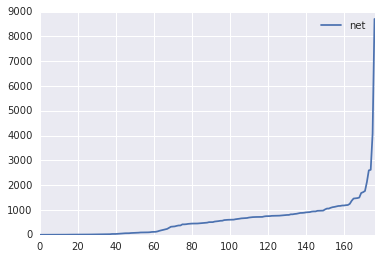

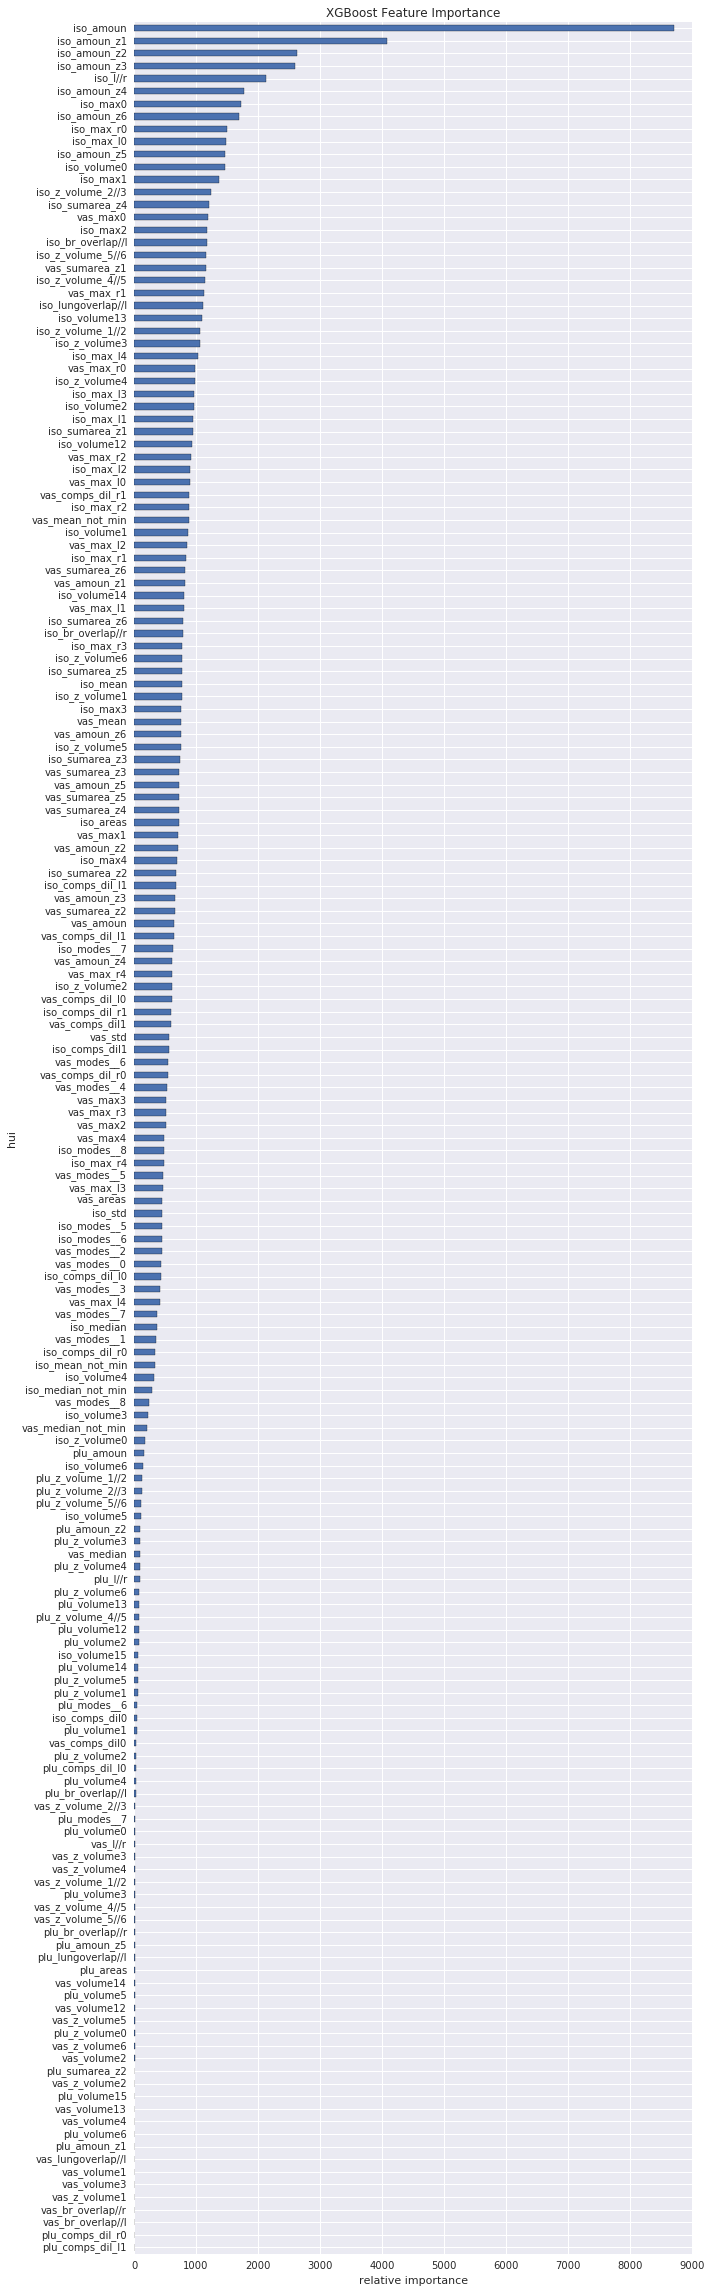

In [108]:
s_list = sorted(clf.booster().get_fscore().items(),key=lambda x: x[1])
df = pd.DataFrame({'hui':[a[0] for a in s_list],'net':[a[1] for a in s_list]})
plt.figure()
df.plot()
df.plot(kind='barh', x='hui', y='net', legend=False, figsize=(10, 40))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()